In [1]:
import pandas as pd

order_table = pd.read_table("season_1/training_data/order_data/order_data_2016-01-01", names=['order_id', 'driver_id', 
               'passenger_id', 'depart_id', 'dest_id', 'price', 'time'], parse_dates=[6])

In [2]:
import numpy as np
import datetime

time_slot = np.zeros((order_table.shape[0],),np.int)
jour = np.zeros((order_table.shape[0],), datetime.date)
for i, t in enumerate(order_table['time']):
    time_slot[i] = t.time().hour*6+t.time().minute/10
    jour[i] = t.date()

In [3]:
order_table['time_slot']=time_slot
order_table['jour']=jour

In [4]:
region_table = pd.read_table("season_1/training_data/cluster_map/cluster_map", index_col=0, names=['hash', 'id'])

In [6]:
order_table_list = []
for d in datelist:
    order_table = pd.read_table("season_1/training_data/order_data/order_data_"+d.isoformat(), 
                                names=['order_id', 'driver_id', 'passenger_id', 'depart_id', 'dest_id', 'price', 'time'], 
                                parse_dates=[6])
    time_slot = np.zeros((order_table.shape[0],),np.int)
    jour = np.zeros((order_table.shape[0],), date)
    for i, t in enumerate(order_table['time']):
        time_slot[i] = t.time().hour*6+t.time().minute/10
        jour[i] = t.date()
    order_table['time_slot']=time_slot
    order_table['jour']=jour
    order_table['depart_id'] = order_table['depart_id'].apply(lambda x: region_table.ix[x, 'id'])
    order_table_list.append(order_table)

In [7]:
order_table = pd.concat(order_table_list).loc[:,['jour', 'depart_id', 'time_slot', 'order_id', 'driver_id']]

In [4]:
f = order_table.groupby(by=['jour', 'depart_id', 'time_slot'], as_index=False).count()

In [1]:
import pandas as pd
from datetime import date, timedelta

startdate = date(2016, 1 ,1)
datelist = [startdate+timedelta(days=i) for i in xrange(0,21)]


In [2]:
import numpy as np


weatherlist = []
for d in datelist:
    weather = pd.read_table("season_1/training_data/weather_data/weather_data_"+d.isoformat(), 
                            names=['time','weather','temperature','pm'], parse_dates=[0])
    time_slot = np.zeros((weather.shape[0],),np.int)
    jour = np.zeros((weather.shape[0],), date)
    for i, t in enumerate(weather['time']):
        time_slot[i] = t.time().hour*6+t.time().minute/10
        jour[i] = t.date()
    weather['slot'] = time_slot
    weather['jour'] = jour
    weatherlist.append(weather)

In [3]:
weather_feature = np.zeros((21*144, 9), dtype = np.float)
grouped_weatherlist = pd.concat(weatherlist).groupby(['jour', 'slot'])
for i in xrange(21):
    for j in xrange(144):
        try:
            rec = grouped_weatherlist.get_group((date(2016,1, 1+i), j))
            for k in xrange(rec.shape[0]):
                weather_feature[i*144+j, rec.iloc[k,1]-1] += 1.0/rec.shape[0]
        except KeyError:
            continue;

In [4]:
b = -1
for e in xrange(weather_feature.shape[0]+1):
    if e==weather_feature.shape[0] or not np.all(weather_feature[e,:]==0.0):
        if e==weather_feature.shape[0]:
            if b!=e-1:
                for i in xrange(b+1, e):
                    weather_feature[i, :] = weather_feature[b, :]
            else:
                break;

        if not np.all(weather_feature[e,:]==0.0) and b!=e-1:
            r = e-b+0.0
            for i in xrange(b+1, e):
                weather_feature[i, :] = (e-i)/r*weather_feature[b, :] + (i-b)/r*weather_feature[e, :]
        elif b==-1 and b!=e-1:
            for i in xrange(b+1, e):
                weather_feature[i, :] = weather_feature[e, :]
        b=e

In [11]:
gf = f.groupby(['jour', 'depart_id', 'time_slot'])

In [12]:
from datetime import timedelta

dd = timedelta(days=7)
t = f.ix[0, 'jour']-dd


In [16]:
gf.get_group((date(2016,1,1), 2, 33))

jour  depart_id  time_slot  order_id  driver_id
170  2016-01-01          2         33         2          1

In [63]:
f.ix[0, 'jour']<f.ix[160000, 'jour']

True

In [40]:
flst = []
# generate time feature
for i in xrange(f.shape[0]):
    x = [(f.ix[i, 'time_slot'], 1), (144+f.ix[i, 'time_slot']/6, 1), (168+f.ix[i, 'jour'].weekday()/5, 1)]
    flst.append(x)

In [41]:
# generate region feature
for i in xrange(f.shape[0]):
    flst[i].append((170+f.ix[i, 'depart_id']-1, 1))

In [42]:
# generate customer feature
from datetime import timedelta

dd = timedelta(days=7)
for i in xrange(f.shape[0]):
    bd = f.ix[i, 'jour']-dd
    try:
        rec = gf.get_group((bd, f.ix[i, 'depart_id'], f.ix[i, 'time_slot']))
        flst[i].append((236, rec.iloc[0, 3]-rec.iloc[0, 4]))
        flst[i].append((237, np.log(1+rec.iloc[0, 3])))
        flst[i].append((238, np.log(1+rec.iloc[0, 4])))
        if rec.iloc[0, 3]==rec.iloc[0, 4]: flst[i].append((239, 1))
    except KeyError:
        continue;

In [52]:
flst[108504]

[(142, 1),
 (167, 1),
 (168, 1),
 (235, 1),
 (236, 0),
 (237, 1.791759469228055),
 (238, 1.791759469228055),
 (239, 1),
 (242, 1.0)]

In [54]:
f.ix[108504,:]

jour         2016-01-14
depart_id            66
time_slot           142
order_id              6
driver_id             6
Name: 108504, dtype: object

In [55]:
weather_feature[]

time  weather  temperature  pm  slot        jour
0  2016-01-21 07:06:27        4          1.0  49    42  2016-01-21
1  2016-01-21 07:16:44        4          1.0  49    43  2016-01-21
2  2016-01-21 07:32:28        4          1.0  49    45  2016-01-21
3  2016-01-21 07:51:38        4          1.0  50    47  2016-01-21
4  2016-01-21 08:12:29        4          1.0  50    49  2016-01-21
5  2016-01-21 08:58:10        4          1.0  49    53  2016-01-21
6  2016-01-21 09:22:50        4          1.0  49    56  2016-01-21
7  2016-01-21 09:47:31        4          1.0  49    58  2016-01-21
8  2016-01-21 19:04:38        4          1.0  44   114  2016-01-21
9  2016-01-21 19:26:20        4          1.0  44   116  2016-01-21
10 2016-01-21 19:36:07        4          2.0  44   117  2016-01-21
11 2016-01-21 19:45:50        4          1.0  48   118  2016-01-21
12 2016-01-21 19:50:38        4          1.0  48   119  2016-01-21
13 2016-01-21 20:01:12        4          1.0  48   120  2016-01-21
14 2016-01-21 20:10:39        4          1.0  48   121  2016-01-21
15 2016-01-21 20:16:09        4          1.0  48   121  2016-01-21
16 2016-01-21 20:25:50        2          1.0  48   122  2016-01-21
17 2016-01-21 20:35:57        2          1.0  48   123  2016-01-21
18 2016-01-21 20:45:47        2          1.0  53   124  2016-01-21
19 2016-01-21 20:56:19        2          1.0  53   125  2016-01-21
20 2016-01-21 21:05:35        2          1.0  53   126  2016-01-21
21 2016-01-21 21:11:22        2          1.0  53   127  2016-01-21
22 2016-01-21 21:21:04        2          1.0  53   128  2016-01-21
23 2016-01-21 21:31:11        2          1.0  53   129  2016-01-21
24 2016-01-21 21:40:58        2          1.0  53   130  2016-01-21
25 2016-01-21 21:51:01        2          1.0  53   131  2016-01-21
26 2016-01-21 22:01:02        2          1.0  53   132  2016-01-21
27 2016-01-21 22:10:53        2          1.0  53   133  2016-01-21
28 2016-01-21 22:20:37        2          1.0  53   134  2016-01-21
29 2016-01-21 22:26:34        2          1.0  53   134  2016-01-21
30 2016-01-21 22:35:24        2          1.0  58   135  2016-01-21
31 2016-01-21 22:40:44        2          1.0  58   136  2016-01-21
32 2016-01-21 22:45:45        2          1.0  58   136  2016-01-21
33 2016-01-21 22:50:34        2          1.0  58   137  2016-01-21
34 2016-01-21 22:55:43        2          1.0  58   137  2016-01-21
35 2016-01-21 23:01:03        2          1.0  58   138  2016-01-21
36 2016-01-21 23:05:50        2          1.0  58   138  2016-01-21
37 2016-01-21 23:11:17        2          1.0  58   139  2016-01-21
38 2016-01-21 23:15:41        2          1.0  58   139  2016-01-21
39 2016-01-21 23:20:52        2          1.0  58   140  2016-01-21
40 2016-01-21 23:25:27        2          1.0  58   140  2016-01-21
41 2016-01-21 23:30:23        2          1.0  58   141  2016-01-21
42 2016-01-21 23:35:24        2          1.0  58   141  2016-01-21
43 2016-01-21 23:40:46        2          1.0  59   142  2016-01-21
44 2016-01-21 23:45:44        2          1.0  59   142  2016-01-21
45 2016-01-21 23:50:31        2          1.0  59   143  2016-01-21
46 2016-01-21 23:55:26        2          1.0  59   143  2016-01-21

In [37]:
rec.iloc[0, 3]

7

In [46]:
np.nonzero(weather_feature[-1,:])

(array([1]),)

In [48]:
weather_feature.shape

(3024, 9)

In [51]:
# weather feature
for i in xrange(f.shape[0]):
    wf = weather_feature[f.ix[i, 'time_slot']+144*(f.ix[i, 'jour'].day-1), :]
    for idx in np.nonzero(wf)[0]:
        flst[i].append((240+idx, wf[idx]))

In [50]:
f.ix[i, 'jour'].day

1

In [56]:
weather_feature[2016:2116,:]

array([[ 0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,

In [58]:
with open("training_data", 'w') as fw:
    for i, features in enumerate(flst):
        s = '{0} {1} '.format(f.ix[i, 'order_id'], f.ix[i, 'driver_id'])
        for idx, val in features:
            if val!=0: s+='{0}:{1} '.format(idx, val)
        s+='\n'
        fw.write(s)

traffic

In [1]:
import pandas as pd

traffic_table = pd.read_table("season_1/training_data/traffic_data/traffic_data_2016-01-01", names=['district', 
               'one', 'two', 'three', 'four', 'time'], parse_dates=[5])
region_table = pd.read_table("season_1/training_data/cluster_map/cluster_map", index_col=0, names=['hash', 'id'])

In [6]:
tf = traffic_table[['one', 'two', 'three', 'four']].applymap(sp)

In [9]:
tf = tf.div(tf.sum(axis=1), axis=0)

In [14]:
slot = traffic_table.time.apply(lambda x: x.hour*6+x.minute/10)

In [19]:
date = traffic_table.time.apply(lambda x: x.day)

In [20]:
district = traffic_table.district.apply(lambda x: region_table.ix[x, 0])

In [22]:
traffic = tf
traffic['slot']=slot
traffic['date']=date
traffic['district']=district

In [34]:
traffic.sort_values(by=['district','slot'], inplace=True)

In [46]:
from datetime import date, timedelta


vtraffic = []
for d in [date(2016,1,1)+timedelta(days=i) for i in xrange(0,21)]:
    traffic_table = pd.read_table("season_1/training_data/traffic_data/traffic_data_"+d.isoformat(), names=['district', 
               'one', 'two', 'three', 'four', 'time'], parse_dates=[5])
    traffic = traffic_table[['one', 'two', 'three', 'four']].applymap(lambda x: int(x.split(':')[1]))
    traffic = traffic.div(traffic.sum(axis=1), axis=0)
    traffic['slot'] = traffic_table.time.apply(lambda x: x.hour*6+x.minute/10)
    traffic['date'] = traffic_table.time.apply(lambda x: x.day)
    traffic['district'] = traffic_table.district.apply(lambda x: region_table.ix[x, 0])
    vtraffic.append(traffic)

In [54]:
grouped_traffic = pd.concat(vtraffic).groupby(['date','district','slot'])

In [61]:
grouped_traffic.size()==1

True

In [1]:
from feature_generation import *

total_order = refine_order_list("season_1/training_data", total_datelist)


In [3]:
grouped_order = total_order.groupby('depart_id')

In [5]:
destrict_order = grouped_order.get_group(12)
gap = destrict_order['order_id']-destrict_order['driver_id']

In [12]:
destrict_order

jour  depart_id  time_slot  order_id  driver_id
1407    2016-01-04         12          0        59         55
1408    2016-01-04         12          1        41         32
1409    2016-01-04         12          2        35         32
1410    2016-01-04         12          3        38         31
1411    2016-01-04         12          4        39         28
1412    2016-01-04         12          5        30         26
1413    2016-01-04         12          6        42         30
1414    2016-01-04         12          7        21         16
1415    2016-01-04         12          8        19         17
1416    2016-01-04         12          9        24         22
1417    2016-01-04         12         10        29         27
1418    2016-01-04         12         11        15         13
1419    2016-01-04         12         12        13         13
1420    2016-01-04         12         13        18         15
1421    2016-01-04         12         14        18         15
1422    2016-01-04         12         15        16          9
1423    2016-01-04         12         16        15         11
1424    2016-01-04         12         17        18         14
1425    2016-01-04         12         18        19         12
1426    2016-01-04         12         19         8          8
1427    2016-01-04         12         20        17          9
1428    2016-01-04         12         21         7          7
1429    2016-01-04         12         22         4          4
1430    2016-01-04         12         23         6          5
1431    2016-01-04         12         24         7          5
1432    2016-01-04         12         25         6          5
1433    2016-01-04         12         26         8          6
1434    2016-01-04         12         27         8          5
1435    2016-01-04         12         28        12          6
1436    2016-01-04         12         29         3          2
...            ...        ...        ...       ...        ...
133314  2016-01-21         12        114       150        145
133315  2016-01-21         12        115       130        127
133316  2016-01-21         12        116       119        113
133317  2016-01-21         12        117       128        126
133318  2016-01-21         12        118       130        126
133319  2016-01-21         12        119       135        129
133320  2016-01-21         12        120       180        176
133321  2016-01-21         12        121       168        164
133322  2016-01-21         12        122       203        193
133323  2016-01-21         12        123       167        165
133324  2016-01-21         12        124       146        140
133325  2016-01-21         12        125       159        157
133326  2016-01-21         12        126       199        186
133327  2016-01-21         12        127       152        145
133328  2016-01-21         12        128       151        146
133329  2016-01-21         12        129       159        153
133330  2016-01-21         12        130       124        121
133331  2016-01-21         12        131       118        114
133332  2016-01-21         12        132       146        133
133333  2016-01-21         12        133       110        107
133334  2016-01-21         12        134       102         95
133335  2016-01-21         12        135       102         95
133336  2016-01-21         12        136        83         83
133337  2016-01-21         12        137        88         85
133338  2016-01-21         12        138        87         84
133339  2016-01-21         12        139        80         73
133340  2016-01-21         12        140        65         63
133341  2016-01-21         12        141        75         71
133342  2016-01-21         12        142        87         68
133343  2016-01-21         12        143       100         50

[2592 rows x 5 columns]

In [10]:
dgap = np.zeros(gap.shape)
for i in xrange(1, dgap.shape[0]):
    dgap[i] = gap.iloc[i]-gap.iloc[i-1]

In [14]:
ddemand = np.zeros(destrict_order['order_id'].shape)
for i in xrange(1, ddemand.shape[0]):
    ddemand[i] = destrict_order['order_id'].iloc[i] - destrict_order['order_id'].iloc[i] 

In [22]:
delta = []
for destrict in xrange(1, 67):
    destrict_order = grouped_order.get_group(destrict).copy()
    gap = destrict_order['order_id']-destrict_order['driver_id']
    dgap = np.zeros(gap.shape)
    for i in xrange(1, dgap.shape[0]):
        dgap[i] = gap.iloc[i]-gap.iloc[i-1]
    ddemand = np.zeros(destrict_order['order_id'].shape)
    for i in xrange(1, ddemand.shape[0]):
        ddemand[i] = destrict_order['order_id'].iloc[i] - destrict_order['order_id'].iloc[i-1]
    destrict_order['dgap']=dgap
    destrict_order['ddemand']=ddemand
    delta.append(destrict_order)
dor = pd.concat(delta)

<IPython.core.display.Javascript object>


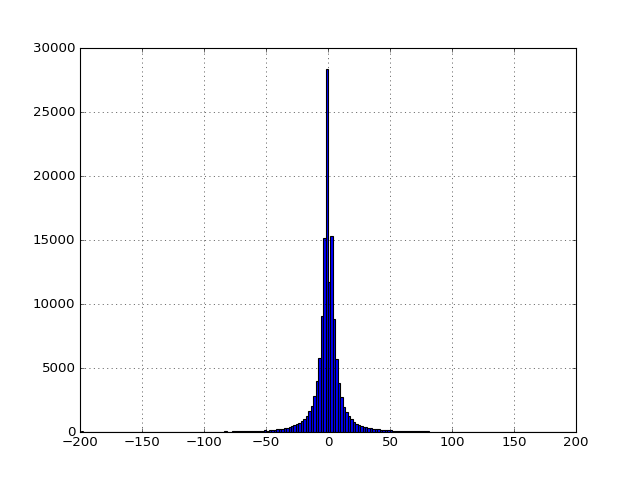

In [36]:
%matplotlib notebook
dor[dor.ddemand.abs()<200].ddemand.hist(bins=200)

In [37]:
dor

jour  depart_id  time_slot  order_id  driver_id  dgap  ddemand
0       2016-01-04          1          0        52         49   0.0      0.0
1       2016-01-04          1          1        47         42   2.0     -5.0
2       2016-01-04          1          2        47         40   2.0      0.0
3       2016-01-04          1          3        42         37  -2.0     -5.0
4       2016-01-04          1          4        37         34  -2.0     -5.0
5       2016-01-04          1          5        23         22  -2.0    -14.0
6       2016-01-04          1          6        33         31   1.0     10.0
7       2016-01-04          1          7        41         32   7.0      8.0
8       2016-01-04          1          8        42         24   9.0      1.0
9       2016-01-04          1          9        17         15 -16.0    -25.0
10      2016-01-04          1         10        27         22   3.0     10.0
11      2016-01-04          1         11        27         22   0.0      0.0
12      2016-01-04          1         12        26         21   0.0     -1.0
13      2016-01-04          1         13        15         12  -2.0    -11.0
14      2016-01-04          1         14        14         14  -3.0     -1.0
15      2016-01-04          1         15        14         14   0.0      0.0
16      2016-01-04          1         16        14         11   3.0      0.0
17      2016-01-04          1         17        11         11  -3.0     -3.0
18      2016-01-04          1         18        12         12   0.0      1.0
19      2016-01-04          1         19        19         13   6.0      7.0
20      2016-01-04          1         20         8          8  -6.0    -11.0
21      2016-01-04          1         21         9          9   0.0      1.0
22      2016-01-04          1         22         5          5   0.0     -4.0
23      2016-01-04          1         23        10          7   3.0      5.0
24      2016-01-04          1         24        15         13  -1.0      5.0
25      2016-01-04          1         25         5          5  -2.0    -10.0
26      2016-01-04          1         26         3          3   0.0     -2.0
27      2016-01-04          1         27         7          6   1.0      4.0
28      2016-01-04          1         28         6          6  -1.0     -1.0
29      2016-01-04          1         29        10         10   0.0      4.0
...            ...        ...        ...       ...        ...   ...      ...
139648  2016-01-21         66        114        19         19   0.0      4.0
139649  2016-01-21         66        115        12         12   0.0     -7.0
139650  2016-01-21         66        116        16         16   0.0      4.0
139651  2016-01-21         66        117        27         27   0.0     11.0
139652  2016-01-21         66        118        14         14   0.0    -13.0
139653  2016-01-21         66        119        16         16   0.0      2.0
139654  2016-01-21         66        120        11         11   0.0     -5.0
139655  2016-01-21         66        121        10         10   0.0     -1.0
139656  2016-01-21         66        122        17         17   0.0      7.0
139657  2016-01-21         66        123        13         12   1.0     -4.0
139658  2016-01-21         66        124        13         11   1.0      0.0
139659  2016-01-21         66        125        13         13  -2.0      0.0
139660  2016-01-21         66        126        10          9   1.0     -3.0
139661  2016-01-21         66        127        12         11   0.0      2.0
139662  2016-01-21         66        128        10         10  -1.0     -2.0
139663  2016-01-21         66        129         9          9   0.0     -1.0
139664  2016-01-21         66        130         9          9   0.0      0.0
139665  2016-01-21         66        131        10          9   1.0      1.0
139666  2016-01-21         66        132         7          7  -1.0     -3.0
139667  2016-01-21         66        133        11         11   0.0      4.0
139668  20

In [1]:
from feature_generation import*

test_order = refine_order_list("season_1/test_set_1", test_datelist)
test_order = test_first_order(test_order, test_datelist)

In [2]:
test_order

jour  depart_id  time_slot  order_id  driver_id  dgap  ddemand
0     2016-01-22          1         42        74         70   0.0      0.0
1     2016-01-22          1         43       128        127  -3.0     54.0
2     2016-01-22          1         44       175        170   4.0     47.0
3     2016-01-22          1         54       269        266  -2.0     94.0
4     2016-01-22          1         55       235        234  -2.0    -34.0
5     2016-01-22          1         56       210        199  10.0    -25.0
6     2016-01-22          1         66       160        158  -9.0    -50.0
7     2016-01-22          1         67       158        152   4.0     -2.0
8     2016-01-22          1         68       169        168  -5.0     11.0
9     2016-01-22          1         78       172        171   0.0      3.0
10    2016-01-22          1         79       191        188   2.0     19.0
11    2016-01-22          1         80       173        168   2.0    -18.0
12    2016-01-22          1         90       165        158   2.0     -8.0
13    2016-01-22          1         91       164        162  -5.0     -1.0
14    2016-01-22          1         92       174        171   1.0     10.0
15    2016-01-22          1        102       345        338   4.0    171.0
16    2016-01-22          1        103       283        266  10.0    -62.0
17    2016-01-22          1        104       257        254 -14.0    -26.0
18    2016-01-22          1        114       241        235   3.0    -16.0
19    2016-01-22          1        115       225        222  -3.0    -16.0
20    2016-01-22          1        116       248        241   4.0     23.0
21    2016-01-22          1        126       287        276   4.0     39.0
22    2016-01-22          1        127       269        257   1.0    -18.0
23    2016-01-22          1        128       233        225  -4.0    -36.0
24    2016-01-22          1        138       122        116  -2.0   -111.0
25    2016-01-22          1        139       119        112   1.0     -3.0
26    2016-01-22          1        140       124        112   5.0      5.0
27    2016-01-22          2         42        20         19   0.0      0.0
28    2016-01-22          2         43        20         18   1.0      0.0
29    2016-01-22          2         44        23         22  -1.0      3.0
...          ...        ...        ...       ...        ...   ...      ...
7894  2016-01-30         65        138         3          3  -1.0      0.0
7895  2016-01-30         65        139         3          3   0.0      0.0
7896  2016-01-30         65        140         3          2   1.0      0.0
7897  2016-01-30         66         42         6          6   0.0      0.0
7898  2016-01-30         66         43         8          8   0.0      2.0
7899  2016-01-30         66         44        10         10   0.0      2.0
7900  2016-01-30         66         54         8          8   0.0     -2.0
7901  2016-01-30         66         55         9          9   0.0      1.0
7902  2016-01-30         66         56        10         10   0.0      1.0
7903  2016-01-30         66         66        14         14   0.0      4.0
7904  2016-01-30         66         67        14         14   0.0      0.0
7905  2016-01-30         66         68        16         16   0.0      2.0
7906  2016-01-30         66         78        15         15   0.0     -1.0
7907  2016-01-30         66         79        15         15   0.0      0.0
7908  2016-01-30         66         80        23         22   1.0      8.0
7909  2016-01-30         66         90        17         17  -1.0     -6.0
7910  2016-01-30         66         91        12         12   0.0     -5.0
7911  2016-01-30         66         92        11         11   0.0     -1.0
7912  2016-01-30         66        102        20         20   0.0      9.0
7913  2016-01-30         66        103        17         17   0.0     -3.0
7914  2016-01-30         66        104        24         22   2.0      7.0
7915  2016-01-30         66        11

visualization

In [10]:
import pandas as pd
import numpy as np
import datetime


region_table = pd.read_table("season_1/training_data/cluster_map/cluster_map", index_col=0, names=['hash', 'id'])

order_table = pd.read_table("season_1/training_data/order_data/order_data_2016-01-01", names=['order_id', 'driver_id', 
               'passenger_id', 'depart_id', 'dest_id', 'price', 'time'], parse_dates=[6])
time_slot = np.zeros((order_table.shape[0],),np.int)
jour = np.zeros((order_table.shape[0],), datetime.date)
for i, t in enumerate(order_table['time']):
    time_slot[i] = t.time().hour*6+t.time().minute/10
    jour[i] = t.date()
order_table['time_slot']=time_slot
order_table['jour']=jour
order_table['depart_id'] = order_table['depart_id'].apply(lambda x: region_table.ix[x, 'id'])
order_table = order_table.loc[:,['jour', 'depart_id', 'time_slot', 'order_id', 'driver_id']]
f = order_table.groupby(by=['jour', 'depart_id', 'time_slot'], as_index=False).count()

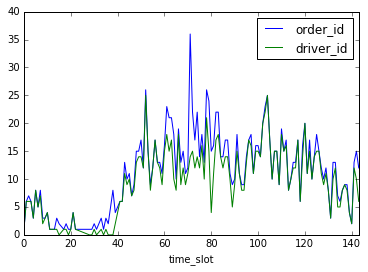

In [27]:
%matplotlib notebook

f[f['depart_id']==13].plot(x='time_slot', y=['order_id', 'driver_id'])

In [5]:
import numpy as np
order_table_list = []
for d in datelist:
    order_table = pd.read_table("season_1/training_data/order_data/order_data_"+d.isoformat(), 
                                names=['order_id', 'driver_id', 'passenger_id', 'depart_id', 'dest_id', 'price', 'time'], 
                                parse_dates=[6])
    time_slot = np.zeros((order_table.shape[0],),np.int)
    jour = np.zeros((order_table.shape[0],), date)
    for i, t in enumerate(order_table['time']):
        time_slot[i] = t.time().hour*6+t.time().minute/10
        jour[i] = t.date()
    order_table['time_slot']=time_slot
    order_table['jour']=jour
    order_table['depart_id'] = order_table['depart_id'].apply(lambda x: region_table.ix[x, 'id'])
    order_table_list.append(order_table)
order_table = pd.concat(order_table_list).loc[:,['jour', 'depart_id', 'time_slot', 'order_id', 'driver_id']]
f = order_table.groupby(by=['jour', 'depart_id', 'time_slot'], as_index=False).count()

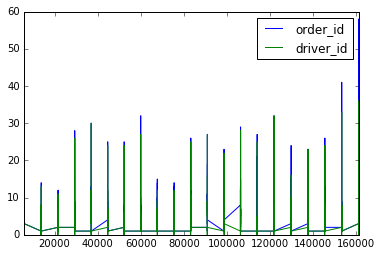

In [33]:
f[f['depart_id']==45].plot(y=['order_id', 'driver_id'])

<IPython.core.display.Javascript object>


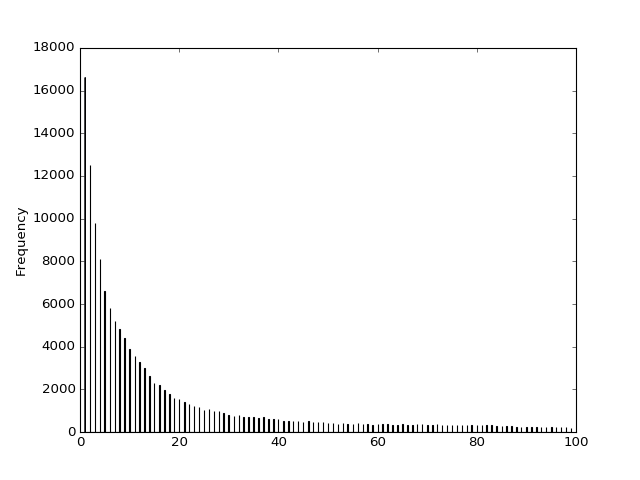

In [31]:
f[f['order_id']<100]['order_id'].plot.hist(bins=1000)

In [17]:
f[f['jour']>date(2016,1,3)]['order_id'].max()

1863

In [18]:
f[f['order_id']==1863]

jour  depart_id  time_slot  order_id  driver_id
161938  2016-01-21         51        103      1863        648

In [23]:
gap = f['order_id']-f['driver_id']

<IPython.core.display.Javascript object>


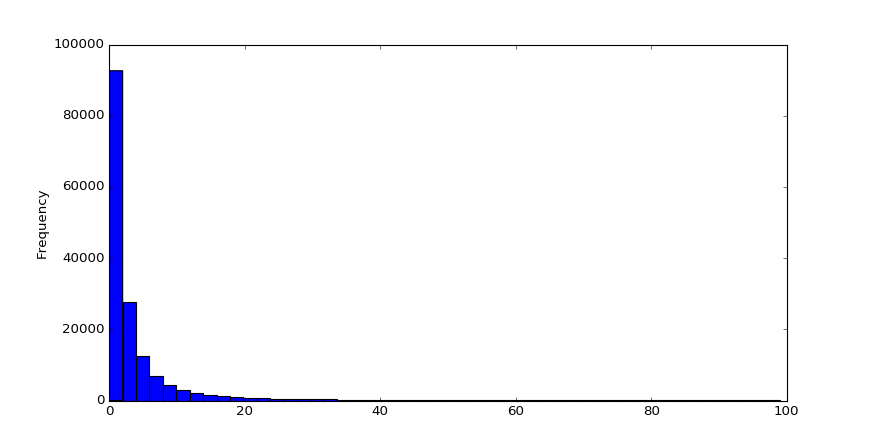

In [32]:
gap[gap<100].plot.hist(bins=50)

In [1]:
from feature_generation import *

In [2]:
weather_feature = weather_feature_generation("season_1/training_data", total_datelist)
# get region table
train_order = refine_order_list("season_1/training_data", train_datelist+validation_datelist)
total_grouped_train_order = train_order.groupby(['jour', 'depart_id', 'time_slot'])


In [5]:
flst = training_data_generation(train_order, total_grouped_train_order, weather_feature)

In [3]:
weather_feature = weather_feature_generation("season_1/test_set_1/", test_datelist)
flst = test_data_generation("season_1/test_set_1/read_me_1.txt", total_grouped_train_order, weather_feature)

In [4]:
len(flst)

2838

refactor?

In [1]:
from feature_generation import *

test_order = refine_order_list("season_1/test_set_2", test_datelist)

In [4]:
for i, j in zip(train_feature, rst[rst].index):
    pass

In [6]:
i

[(143, 1), (167, 1), (168, 1), (235, 1), (239, 1), (267, 1.0)]